# Lecture 11: Finite source inversion
## GEO 371T/391: Earthquakes
### Prof. Daniel Trugman, 2021

In [1]:
### Import General Python Packages

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10

# Overview

The inversion of geophysical data (seismic, geodetic, tsunami, etc.) to describe earthquake rupture processes is an important research area in earthquake science. Research in this particular field is moving rather fast, and would take a whole course in an of itself to cover in full detail. Since we are only spending a single class period on this topic, we can't hope to develop the skills necessary to practice finite fault inversion at the present state of the art. Instead, this notebook will give something of a survey or overview of basic concepts and tools you will need to understand if you decide to pursue this type of research further.

In this notebook, we will get some experience navigating SRCMOD, which is the largest online database of finite fault slip inversion results. We will then examine the approach of Okada [1992] that is widely to compute the static, surface displacement field of earthquakes - providing a solution to the forward problem for geodetic inversions. Finally, we will learn by example how back-projection can be used to provide a non-parametric and complementary image to traditional slip inversions.

## Example 1: SRCMOD

SRCMOD (http://equake-rc.info/srcmod/) is an online database of finite fault rupture models. To date, the repository contains more than 400 different models corresponding to nearly 200 unique earthquakes (some earthquakes have multiple models in the database). Published models are uploaded by the authors and made publicly available in several uniform formats. This makes the SRCMOD database a great research tool for a number of different problems.

All models in the database are documented following the standards laid out by Mai et al. [2016]. Each model has its own webpage, with downloads available in multiple formats. The text file formats (.slp, .fsp) are easiest to understand from a human author, but the .mat files are the most straightforward to load into a computer. While these are designed for use in matlab, they are simple to extract into a Jupyter notebook. 

---

For example, consider this model of the Amatrice, Italy earthquake:

In [4]:
### Test load a model

## use loadmat for easy I/O
from scipy.io import loadmat

## load model
model_name = "s2016AMATRI01PIZZ"
smod = loadmat("data/"+model_name+".mat",
               simplify_cells=True)[model_name]

## print out event information
print("Event:",smod['event'])
print("Reference:",smod['invAUTH'])
print("Event date:",smod['evDAT'])
print("Mw and M0:", smod['srcMwMoS'])


Event: Amatrice 
Reference: Pizzi et al. (2017) 
Event date: 08/24/2016
Mw and M0: [6.21e+00 2.60e+18]


---

Along with event metadata, ``smod`` also contains the slip model and information needed to plot or otherwise analyze it.

In [5]:
## Fault geometry
nseg = int(smod['invSEGM'])
print("Number of segments:",nseg)
print("Nz and Nx:",smod['invNzNx'])
print("dz and dx:", smod['invDzDx'])

## Peak slip, likely in cm
peak_slip = np.max(smod['slipSPL'])
print("Peak slip [cm]:",peak_slip)

Number of segments: 1
Nz and Nx: [12. 30.]
dz and dx: [1.  1.2]
Peak slip [cm]: 49.669999999999995


---

For a single-segment rupture, we can visualize the slip model as follows:

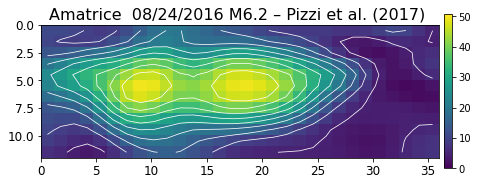

In [6]:
### Plot slip model

## load model
model_name = "s2016AMATRI01PIZZ"
smod = loadmat("data/"+model_name+".mat",
               simplify_cells=True)[model_name]

## figure setup
plt.close('all')
fig, axi = plt.subplots(1,1,figsize=(8.5,8.5))

# extract geometry
nz, nx = int(smod['invNzNx'][0]), int(smod['invNzNx'][1])
dz, dx = smod['invDzDx']
xx = np.arange(0,nx*dx+dx/10,dx)
zz = np.arange(0,nz*dz+dz/10,dz)
aspect = zz[-1]/xx[-1]

# plot slip model
peak_slip = np.max(smod['slipSPL'])
h = axi.pcolormesh(xx,zz,smod['slipSPL'],vmin=0,vmax=peak_slip+1)

# slip contours
xxc = xx[0:-1]+dx/2
zzc = zz[0:-1]+dz/2
peak_slip = np.max(smod['slipSPL'])
levels = np.linspace(0,peak_slip,11)
axi.contour(xxc,zzc,smod['slipSPL'],levels=levels,
            colors='w',linewidths=0.75)

# title
ttlstr = '{:} {:} M{:.1f} – {:}'.format(
   smod['event'],smod['evDAT'],smod['srcMwMoS'][0],smod['invAUTH'])
axi.set_title(ttlstr,fontsize=16)

# format
axi.set_ylim(zz[-1],zz[0])
cb = plt.colorbar(h,ax=axi,shrink=aspect,pad=0.01)
axi.set_aspect('equal')
axi.tick_params(labelsize=12)

# show plot
plt.show()
plt.close()

---

From the model, you can see there are two main slip patches at a depth of about 5km. Peak slip is about 50cm, and the total fault length is about 30km.

Let's look at another example from the same group:

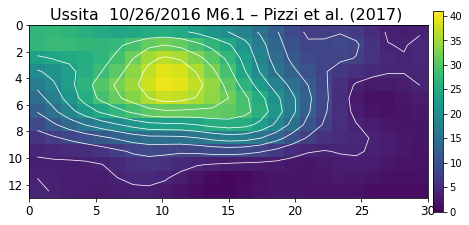

In [8]:
### Plot slip model

## load model
model_name = "s2016USSITA01PIZZ"
smod = loadmat("data/"+model_name+".mat",
               simplify_cells=True)[model_name]

## figure setup
plt.close('all')
fig, axi = plt.subplots(1,1,figsize=(8.5,8.5))

# extract geometry
nz, nx = int(smod['invNzNx'][0]), int(smod['invNzNx'][1])
dz, dx = smod['invDzDx']
xx = np.arange(0,nx*dx+dx/10,dx)
zz = np.arange(0,nz*dz+dz/10,dz)
aspect = zz[-1]/xx[-1]

# plot slip model
peak_slip = np.max(smod['slipSPL'])
h = axi.pcolormesh(xx,zz,smod['slipSPL'],vmin=0,vmax=peak_slip+1)

# slip contours
xxc = xx[0:-1]+dx/2
zzc = zz[0:-1]+dz/2
levels = np.linspace(0,peak_slip,11)
axi.contour(xxc,zzc,smod['slipSPL'],levels=levels,colors='w',linewidths=0.75)

# title
ttlstr = '{:} {:} M{:.1f} – {:}'.format(
   smod['event'],smod['evDAT'],smod['srcMwMoS'][0],smod['invAUTH'])
axi.set_title(ttlstr,fontsize=16)

# format
axi.set_ylim(zz[-1],zz[0])
cb = plt.colorbar(h,ax=axi,shrink=aspect,pad=0.01)
axi.set_aspect('equal')
axi.tick_params(labelsize=12)

# show plot
plt.show()
plt.close()


In this event (Ussita), peak slip is lower and a bit shallower. It's worth noting that this plotting code does not attempt to show the dip of the fault, so we are looking at the fault head-on, in the direction of the normal vector.

My guess is that this research group uses high-quality, modern data (the model is from 2017), but that they apply a fair amount of smoothing to regularize the inversion. Full details on this can of course be obtained on the website.

In general, the older earthquakes in the dataset are less well-resolved. For example, consider the 1999 Duzce, Turkey event:



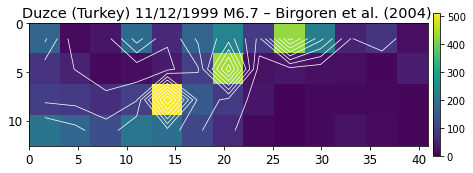

In [10]:
### Plot slip model

## load model
model_name = "s1999DUZCET01BIRG"
smod = loadmat("data/"+model_name+".mat",
               simplify_cells=True)[model_name]

## figure setup
plt.close('all')
fig, axi = plt.subplots(1,1,figsize=(8.5,8.5))

# extract geometry
nz, nx = int(smod['invNzNx'][0]), int(smod['invNzNx'][1])
dz, dx = smod['invDzDx']
xx = np.arange(0,nx*dx+dx/10,dx)
zz = np.arange(0,nz*dz+dz/10,dz)
aspect = zz[-1]/xx[-1]

# plot slip model
peak_slip = np.max(smod['slipSPL'])
h = axi.pcolormesh(xx,zz,smod['slipSPL'],vmin=0,vmax=peak_slip+1)

# slip contours
xxc = xx[0:-1]+dx/2
zzc = zz[0:-1]+dz/2
levels = np.linspace(0,peak_slip,11)
axi.contour(xxc,zzc,smod['slipSPL'],levels=levels,
            colors='w',linewidths=0.75)

# title
ttlstr = '{:} {:} M{:.1f} – {:}'.format(
   smod['event'],smod['evDAT'],smod['srcMwMoS'][0],smod['invAUTH'])
axi.set_title(ttlstr,fontsize=14.5)

# format
axi.set_ylim(zz[-1],zz[0])
cb = plt.colorbar(h,ax=axi,shrink=aspect,pad=0.01)
axi.set_aspect('equal')
axi.tick_params(labelsize=12)

# show plot
plt.show()
plt.close()

---

Here, we can see basically 3 main asperities (patches of high slip). I'm not sure how much I would trust this one...

We'll get more practice with these slip models in the homework assignments.

## Example 2: Okada's Solution

Source inversions using geodetic data - satellite radar, GPS, etc. - are typically constrained through measurements of surface displacement. Mathematically, the inverse problem can be summarized as: given observations of surface displacement, what are the details of the source that caused it.

To solve the inverse problem, we first need to be able to solve the forward problem. Given a distribution of slip at depth (a dislocation model), what do the surface displacements look like? Okada's famous paper "Internal deformation due to shear and tensile faults in a half-space" [BSSA, 1992] provided the answer that is widely used today.

---

A bit of historical context is in order. Steketee [1958] showed that the displacement field $\Delta u_i$ at an observation point $(x_1, x_2, x_3)$ at a source position $(\xi_1, \xi_2, \xi_3)$ can be written using Volterra's formula:

\begin{equation}
u_i = \int \int_\Sigma \Delta u_j \left[ \lambda \frac{\partial g_i^n}{\partial \xi_n} \delta_{jk} + \mu \left(\frac{\partial g_i^j}{\partial \xi_k} + \frac{\partial g_i^k}{\partial \xi_j} \right) \right] \nu_k \, d \Sigma, 
\end{equation}

where $\lambda$ and $\mu$ are elastic constants and $\nu_k$ i the component of the normal vector of the dislocation surface $\Sigma$.


---

Conceptually, Volterra’s formula represents the displacement field as an integral over double-couple sources distributed across the fault plane. Once the source distribution is known, the displacement field for the entire medium can be obtained directly. Okada [1992] applied this basic paradigm to provide analytical solutions for the elastic fields due to finite rectangular sources. Though these analytic Green’s functions are complicated in form (I will not transcribe them here!), this framework provides an efficient method to compute displacement and strain fields for an arbitrary distribution of rectangular sources.

---

The formulation of Okada [1992] is a simplified form of a more general class of *boundary element techniques* [Crouch and Starfield, 1983] that are commonly applied in elastostatic problems. As with all boundary element techniques, only the interior boundary of the computational domain is explicitly discretized. The Green’s functions in question satisfy both the governing partial differential equation (static equilibrium) and the far-field boundary conditions (traction-free surface and vanishing displacements at infinity), precluding the need to discretize the rest of the computational domain (as in a finite element method, for example). However, because we apply Dirichlet boundary conditions along the interior boundary (i.e., prescribed slip on each fault element), we obviate the need to solve for the source intensity using the matrix of influence coefficients, as is standard in more general boundary element problems. Such "kinematic" problems differ from "dynamic" problems in which one applies stress (Neumann) boundary conditions and uses the matrix of influence coefficients to solve for the slip that satisfies the prescribed stresses. In either class of boundary element problem, once we have the values of slip for each fault element that satisfy the prescribed boundary conditions, the final solution in the computational domain is obtained through superposition of the elementary solutions
(scaled Green’s functions) for each fault element.

---

How is this useful in practice? Well, nearly all geodetic inversions use Okada's Green's functions to solve the forward problem. While these functions have a complicated functional form, there are analytic and rapid to compute.

In this example, we'll use the python package ``okada_wrapper`` available at this website: https://github.com/tbenthompson/okada_wrapper. There are also equivalent packages available for Matlab, and original code was written in Fortran.

The easiest way to install is via the command line:

`pip install okada_wrapper`

Note: for this code to run, you will need a fortran compiler (gfortran is free and recommended).



---

This code allows us to calculate both the displacement field and its gradient for either point sources (`dc3d0wrapper`) or finite rectangular dislocations (``dc3dwrapper``).

For `dc3d0wrapper`, the basic syntax is:

``success, u, grad_u = dc3d0wrapper(alpha, xobs, sdep, sdip, potency)``

where the inputs are:
* alpha = (lambda + mu) / (lambda + 2 * mu)
* xobs = 3-vector representing the observation point
* sdep = the depth of the slip plane
* sdip = the dip-angle of the slip plane in degrees
* potency = 4-vector of potency components:
    0. strike-slip = Moment of double-couple / mu
    1. dip-slip = Moment of double-couple / mu
    2. inflation = Intensity of isotropic part / lambda
    3. tensile = Intensity of linear dipole / mu
    
and the outputs are:
* success = a return code where 0 is good, 1 is singular (no bueno), 2 if a positive z-value was given for the observation point (which needs to be <= 0 in their system)
* u = 3-vector (x,y,z) representing the displacement at the observation point.
* grad_u = the 3x3 tensor representing the partial derivatives of the displacement, for example, grad_u(0, 1) = d(u_x)/dy


---
For example, a test of `dc3d0wrapper` would be:

In [11]:
## Test dc3d0wrapper
from okada_wrapper import dc3d0wrapper
success, u, grad_u = dc3d0wrapper(0.6, [1.0, 1.0, -1.0], 3.0,
                                  1.0, [1.0, 0.0, 0.0, 0.0])

## Print results
assert success == 0 # make sure it worked
print("u:\n",u)
print("\ngrad_u:\n",grad_u)


ImportError: cannot import name 'dc3d0wrapper' from 'okada_wrapper' (unknown location)

For `dc3dwrapper`, the basic syntax is:

``success, u, grad_u = dc3dwrapper(alpha, xobs, sdep, sdip, swidth1, swidth2, dislocation)``

where the inputs are:
* alpha = (lambda + mu) / (lambda + 2 * mu)
* xobs = 3-vector representing the observation point
* sdep = the depth of the fault origin
* sdip = the dip-angle of the dislocation surface
* strike_span = along-strike range of the surface
* dip_span = along-dip range of the surface
* dislocation = 3-vector of slip on the surface (strike-slip, dip-slip, opening)
    
and the outputs are identical to `dc3dwrapper0`:
* success = a return code where 0 is good, 1 is singular (no bueno), 2 if a positive z-value was given for the observation point (which needs to be <= 0 in their system)
* u = 3-vector (x,y,z) representing the displacement at the observation point.
* grad_u = the 3x3 tensor representing the partial derivatives of the displacement, for example, grad_u(0, 1) = d(u_x)/dy

---
For example, a test of `dc3dwrapper` would be:

In [ ]:
## Test dc3dwrapper
from okada_wrapper import dc3dwrapper
success, u, grad_u = dc3dwrapper(0.6, [1.0, 1.0, -1.0], 3.0,
                                    90, [-0.7, 0.7], [-0.7, 0.7],
                                    [1.0, 0.0, 0.0])

## Print results
assert success == 0 # make sure it worked
print("u:\n",u)
print("\ngrad_u:\n",grad_u)




---

Ok, now that we know how the code runs (and how to run the code), let's take a look at some examples. 

Let's place a finite, rectangular source at depth and take a look at the displacement field at the same depth.

In [ ]:
### Plot results for a test model

# define parameters
source_depth = 3.0 # center of fault
obs_depth = 3.0 # observation depth same as source
poisson_ratio = 0.25 # poisson solid
mu = 1.0 # in some normalized units
dip = 90 # vertical 
lmda = 2 * mu * poisson_ratio / (1 - 2 * poisson_ratio) # lame parameter
alpha = (lmda + mu) / (lmda + 2 * mu) # normalized moduli
slip = [1.0, 0.0, 0.0] # pure strike slip

# define grid to make calculations
n = (100, 100)
x = np.linspace(-1, 1, n[0])
y = np.linspace(-1, 1, n[1])
ux = np.zeros((n[0], n[1]))
uy = np.zeros((n[0], n[1]))
uz = np.zeros((n[0], n[1]))

# at each observation point, compute displacement
for i in range(n[0]):
    for j in range(n[1]):
        
        # calculate
        success, u, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the obs depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-0.6, 0.6], [-0.6, 0.6], # a square dislocation, 1.2 x 1.2
            slip)          # slip vector
        
        # check
        assert(success == 0)
        
        # save ux, uy, uz
        ux[i, j] = u[0]
        uy[i, j] = u[1]
        uz[i, j] = u[2]
        

# figure setup
fig, axi = plt.subplots(1,2,figsize=(16,7.5),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05)
        
# chose colorscale for plot
print(np.max(ux))
print(np.max(uy))
levels = np.linspace(-0.5, 0.5, 21)

# plot ux
cntrf = axi[0].contourf(x, y, ux.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[0].contour(x, y, ux.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[0].set_xlabel('x',fontsize=20)
axi[0].set_ylabel('y',fontsize=20)
axi[0].set_title("$u_x$",fontsize=20)

# plot uy
levels = np.linspace(-0.5, 0.5, 21)
cntrf = axi[1].contourf(x, y, uy.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[1].contour(x, y, uy.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[1].set_xlabel('x',fontsize=20)
axi[1].set_title("$u_y$",fontsize=20)



# show plot
fig.suptitle("Displacement",fontsize=20)
plt.show()
plt.close()

---

This makes sense. This is a vertical, left-lateral fault (slip is in the x-direction). These "butterfly" patterns are pretty typical of dislocation models.

**Question**: Based on the contours, how does the displacement field falloff with distance $r$ from the fault?

---

Using the gradient output, we can also plot the strain field. For example, recall the x-y shear strain is

\begin{equation}
e_{xy} = \frac{1}{2}\left(\frac{\partial u_y}{\partial x} + \frac{\partial u_x} {\partial y} \right)
\end{equation}

In [ ]:
# define parameters
source_depth = 3.0 # center of fault
obs_depth = 3.0 # observation depth same as source
poisson_ratio = 0.25 # poisson solid
mu = 1.0 # in some normalized units
dip = 90 # vertical
lmda = 2 * mu * poisson_ratio / (1 - 2 * poisson_ratio) # lame parameter
alpha = (lmda + mu) / (lmda + 2 * mu) # normalized moduli
slip = [1.0, 0.0, 0.0] # pure strike slip

# define grid to make calculates
n = (100, 100)
x = np.linspace(-1, 1, n[0])
y = np.linspace(-1, 1, n[1])
exy = np.zeros((n[0], n[1]))

# at each observation point, compute displacement
for i in range(n[0]):
    for j in range(n[1]):
        
        # calculate
        success, u, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the obs depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-0.6, 0.6], [-0.6, 0.6], # a square dislocation, 1.2 x 1.2
            slip)          # slip vector
        
        # check
        assert(success == 0)
        
        # save strain
        exy[i,j] = (grad_u[0,1]+grad_u[1,0])/2
        

# figure setup
fig, axi = plt.subplots(1,1,figsize=(8,8))
        
# chose colorscale for plot
print(np.max(exy))
levels = np.linspace(-0.75, 0.75, 21)

# plot ux
cntrf = axi.contourf(x, y, exy.T, levels = levels, cmap = plt.cm.RdYlBu_r)
axi.contour(x, y, exy.T, colors = 'k', levels = levels, linestyles = 'solid')
axi.set_xlabel('x',fontsize=20)
axi.set_ylabel('y',fontsize=20)
axi.set_title("$e_{xy}$",fontsize=20)


# show plot
plt.show()
plt.close()

---

This plot is kind of messy, but a few things to notice:
- most of the "action" is at the tips of the dislocation
- slip on the fault imposes a strain change along its trace
- strains fall off in the far field more rapidly than displacements.

We'll have a change to play around more with these codes in the homework and later lectures.

## Example 3: Back-projection

Back-projection provides an alternative framework for imaging an earthquake source that requires markedly fewer assumptions: no need to specify a fault geometry or rupture velocity, for example. Back-projection is an application of reciprocity, essentially rewinding seismic recordings back to the source than generated them. The basic idea is that if we have a collection of seismic waveforms recorded at different stations, if we time shift them back to the true source location, they will align (stack) coherently. If not, the stack will be incoherent. Thus back-projection is the game of searching for coherent sources of seismic energy.

---

In this example (adapted from a SCEC-ERI summer school), we will perform a simple back-projection exercise assuming a constant velocity model (which makes the time shifting trivial). In this scenario, you have access to a tremor dataset recorded on a 20-station seismic network. Each station records 250s of data at 20Hz: 5000 data points in total. 

We have reason to believe that the tremor is located at 30 km depth and the the crust has a uniform P-velocity of 6km/s. The goal for this problem is to find the likey source (or sources) of the tremor. 

---

First things first, we need to get the data. The station locations are saved to the text file "tremor_stations.txt" and the tremor data to a text file "tremor_data.txt".

We can load this data as follows:

In [ ]:
### Load tremor data

# stations
staXY = np.loadtxt("data/tremor_stations.txt")
print("Stations:\n",staXY)

# tremor data
tdata = np.loadtxt("data/tremor_data.txt")
npts, nsta = tdata.shape
print("\nTremor data:",npts, nsta)
print(tdata)

# time points
dt = 1.0/20.0 # sampling delta
tt = np.arange(0.0,250.0,dt)
print("\nTime points:\n",tt)


--- 

Before diving in, it's always a good idea to plot the raw data. Let's take a look. 

In [ ]:
### Plot time series

# figure setup
fig, axi = plt.subplots(20,1,sharex=True,figsize=(14,24))
fig.subplots_adjust(hspace=0.05)

# plot data from each station
for ii in range(20):
    axi[ii].plot(tt,tdata[:,ii],"-k")
    axi[ii].set_ylabel("Site %02d" %ii)

# show plot    
axi[-1].set_xlabel("Time (s)")
axi[-1].set_xlim(-10,260)
plt.show()
plt.close()

---

Yikes, that looks like noise! If there is any signal in there, it is buried deep.

Let's soldier on and look for possible tremor sources. Recall that we know that a source, if one exists, is likely to be at 30km depth. We also know the P-wave speed of 6km/s. For back projection, we need to do a grid search over trial source locations, shift the traces according to the expected lack (controlled by the source-site distance), and stack the results.

Here, let's use a grid with spacing of 1km and bounds of [0km, 100km], pretty much the footprint of our network. While there are more advanced approaches to stacking, we'll use a simple RMS here.

In [ ]:
### BACK PROJECTION

# define problem parameters
c = 6.0 # wavespeed
dep = 30.0 # depth

# set up grid
xgrid = np.linspace(0,100,101)
ygrid = np.linspace(0,100,101)
XX, YY = np.meshgrid(xgrid,ygrid)

# store BP values for each point
BP = np.zeros_like(XX)

# loop over grid points
for ii in range(ygrid.size):
    for jj in range(xgrid.size):
        
        # initialize empty stack
        stack = np.zeros(npts)
        maxshift = 0
        
        # loop over stations
        for kk in range(nsta):
            
            # compute distance and travel time
            dist = np.sqrt((XX[ii,jj]-staXY[kk,0])**2 + (
                YY[ii,jj]-staXY[kk,1])**2 + dep**2)
            tshift = dist/c
            
            # shift data, add to stack
            ishift = int(tshift/dt)
            stack+=np.roll(tdata[:,kk],-ishift)
            
            # track maximum shift, since np.roll is a circular shift
            maxshift = max(ishift,maxshift)
        
        # BP value = RMS of the stack (excluding edge effects)
        BP[ii,jj] = np.sqrt(np.mean(stack[0:-maxshift]**2))
            

# setup plot
fig,axi= plt.subplots(1,1,figsize=(9,8))

# plot BP data and stations
cc = axi.pcolormesh(XX,YY,BP,shading="auto")
axi.plot(staXY[:,0],staXY[:,1],"r^")
plt.colorbar(cc,pad=0.02,aspect=40)

# show results
plt.show()
plt.close()

---

Wow, despite the noise, we were able to image three distinct tremor sources! Pretty cool, if you ask me.

# HOMEWORK

## Problem 1: SRCMOD Model Comparison

Visit the SRCMOD website (http://equake-rc.info/srcmod/) and look up results for an earthquake of interest that includes slip models from multiple authors (e.g., Parkfield, 2004 or L'Aquila, 2009). 


* Download the .mat files for each slip model, and plot them together using a uniform colorscale for slip and a comparable geometric scale.

* What do you notice about the similarities and differences between inversion results of the different models? What factors might explain the differences? Note that you can find more details about the basic inversion approach on the model webpage.

<font color='blue'>

**ANSWER**
    
Here are three models for Parkfield (2004). The inversion results are very different! They may use different inversion approaches or regularization and different types of data.
    
</font>

In [ ]:
### Plot slip models

## Setup
models = ["s2004PARKFI01CUST",
          "s2004PARKFI01DREG",
          "s2004PARKFI01JIxx"] # Parkfield models
cmin, cmax = 0, 100
levels = np.linspace(0,80,9)


## Loop over models
for model_name in models:
    smod = loadmat("data/"+model_name+".mat",
               simplify_cells=True)[model_name]

    ## figure setup
    plt.close('all')
    fig, axi = plt.subplots(1,1,figsize=(8.5,8.5))

    # extract geometry
    nz, nx = int(smod['invNzNx'][0]), int(smod['invNzNx'][1])
    dz, dx = smod['invDzDx']
    xx = np.arange(0,nx*dx+dx/10,dx)
    zz = np.arange(0,nz*dz+dz/10,dz)
    aspect = zz[-1]/xx[-1]

    # plot slip model
    peak_slip = np.max(smod['slipSPL'])
    h = axi.pcolormesh(xx,zz,smod['slipSPL'],vmin=cmin,vmax=cmax)

    # slip contours
    xxc = xx[0:-1]+dx/2
    zzc = zz[0:-1]+dz/2
    axi.contour(xxc,zzc,smod['slipSPL'],levels=levels,colors='w',linewidths=0.75)

    # title
    ttlstr = '{:} {:} M{:.1f} – {:}'.format(
       smod['event'],smod['evDAT'],smod['srcMwMoS'][0],smod['invAUTH'])
    axi.set_title(ttlstr,fontsize=13)

    # format
    axi.set_ylim(zz[-1],zz[0])
    cb = plt.colorbar(h,ax=axi,shrink=aspect,pad=0.01)
    axi.set_aspect('equal')
    axi.tick_params(labelsize=12)

    # show plot
    plt.show()
    plt.close()

## Problem 2: Okada, continued

**Question 2(a)**

In the example above, we examined the displacement field for a finite dislocation. Placing the source at the same depth, make similar plots for a *point source* using ``dc3d0wrapper``. How do the displacement fields differ from that of a finite source?

<font color='blue'>

**ANSWER**
    
We still have a basic butterfly pattern, but the displacements are much more localized about the point source. For obvious reasons, there is a symmetry with $u_x$ and $u_y$ that is not there for a finite source. 
    
</font>

In [ ]:
### Plot results for a test model

# define parameters
source_depth = 3.0 # center of fault
obs_depth = 3.0 # observation depth same as source
poisson_ratio = 0.25 # poisson solid
mu = 1.0 # in some normalized units
dip = 90 # vertical
lmda = 2 * mu * poisson_ratio / (1 - 2 * poisson_ratio) # lame parameter
alpha = (lmda + mu) / (lmda + 2 * mu) # normalized moduli
potency = [1.0, 0.0, 0.0, 0.0] # for a point source

# define grid to make calculations
n = (100, 100)
x = np.linspace(-1, 1, n[0])
y = np.linspace(-1, 1, n[1])
ux = np.zeros((n[0], n[1]))
uy = np.zeros((n[0], n[1]))
uz = np.zeros((n[0], n[1]))

# at each observation point, compute displacement
for i in range(n[0]):
    for j in range(n[1]):
        
        
        
        # calculate with this syntax:
        #``success, u, grad_u = dc3d0wrapper(alpha, xobs, sdep, sdip, potency)``
        success, u, grad_u = dc3d0wrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the obs depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
           potency)          # potency
        
        # check
        assert(success == 0)
        
        # save ux, uy, uz
        ux[i, j] = u[0]
        uy[i, j] = u[1]
        uz[i, j] = u[2]
        

# figure setup
fig, axi = plt.subplots(1,2,figsize=(16,7.5),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05)
        
# chose colorscale for plot
print(np.max(ux))
print(np.max(uy))
levels = np.linspace(-1.5, 1.5, 31)

# plot ux
cntrf = axi[0].contourf(x, y, ux.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[0].contour(x, y, ux.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[0].set_xlabel('x',fontsize=20)
axi[0].set_ylabel('y',fontsize=20)
axi[0].set_title("$u_x$",fontsize=20)

# plot uy
levels = np.linspace(-1.5, 1.5, 31)
cntrf = axi[1].contourf(x, y, uy.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[1].contour(x, y, uy.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[1].set_xlabel('x',fontsize=20)
axi[1].set_title("$u_y$",fontsize=20)

# show plot
plt.show()
plt.close()

**Question 2(b)**

The finite dislocation in our example is for a vertical strike-slip fault. How do the displacement fields compare with these cases:

- pure dip-slip on a fault with a dip of 45 degrees
- pure opening on a fault with a dip of 90 degrees
- oblique mixed slip on a fault with a dip of 45 degrees


<font color='blue'>

**ANSWER**

Pure dip-slip, 45 degree dip. Notice that now most of the displacement is in y.

</font>

In [ ]:
### Plot results for a test model

# define parameters
source_depth = 3.0 # center of fault
obs_depth = 3.0 # observation depth same as source
poisson_ratio = 0.25 # poisson solid
mu = 1.0 # in some normalized units
dip = 45 # dipping now
lmda = 2 * mu * poisson_ratio / (1 - 2 * poisson_ratio) # lame parameter
alpha = (lmda + mu) / (lmda + 2 * mu) # normalized moduli
slip = [0.0, 1.0, 0.0] # pure dip slip

# define grid to make calculations
n = (100, 100)
x = np.linspace(-1, 1, n[0])
y = np.linspace(-1, 1, n[1])
ux = np.zeros((n[0], n[1]))
uy = np.zeros((n[0], n[1]))
uz = np.zeros((n[0], n[1]))

# at each observation point, compute displacement
for i in range(n[0]):
    for j in range(n[1]):
        
        # calculate
        success, u, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the obs depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-0.6, 0.6], [-0.6, 0.6], # a square dislocation, 1.2 x 1.2
            slip)          # slip vector
        
        # check
        assert(success == 0)
        
        # save ux, uy, uz
        ux[i, j] = u[0]
        uy[i, j] = u[1]
        uz[i, j] = u[2]
        

# figure setup
fig, axi = plt.subplots(1,2,figsize=(16,7.5),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05)
        
# chose colorscale for plot
print(np.max(ux))
print(np.max(uy))
levels = np.linspace(-0.5, 0.5, 21)

# plot ux
cntrf = axi[0].contourf(x, y, ux.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[0].contour(x, y, ux.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[0].set_xlabel('x',fontsize=20)
axi[0].set_ylabel('y',fontsize=20)
axi[0].set_title("$u_x$",fontsize=20)

# plot uy
levels = np.linspace(-0.5, 0.5, 21)
cntrf = axi[1].contourf(x, y, uy.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[1].contour(x, y, uy.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[1].set_xlabel('x',fontsize=20)
axi[1].set_title("$u_y$",fontsize=20)



# show plot
fig.suptitle("Dip Slip Motion",fontsize=20)
plt.show()
plt.close()

<font color='blue'>

**ANSWER**

Pure opening, 90 deg dip. For a vertical fault with this strike, opening is in $u_y$.

</font>

In [ ]:
### Plot results for a test model

# define parameters
source_depth = 3.0 # center of fault
obs_depth = 3.0 # observation depth same as source
poisson_ratio = 0.25 # poisson solid
mu = 1.0 # in some normalized units
dip = 90 # vertical
lmda = 2 * mu * poisson_ratio / (1 - 2 * poisson_ratio) # lame parameter
alpha = (lmda + mu) / (lmda + 2 * mu) # normalized moduli
slip = [0.0, 0.0, 1.0] # pure opening

# define grid to make calculations
n = (100, 100)
x = np.linspace(-1, 1, n[0])
y = np.linspace(-1, 1, n[1])
ux = np.zeros((n[0], n[1]))
uy = np.zeros((n[0], n[1]))
uz = np.zeros((n[0], n[1]))

# at each observation point, compute displacement
for i in range(n[0]):
    for j in range(n[1]):
        
        # calculate
        success, u, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the obs depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-0.6, 0.6], [-0.6, 0.6], # a square dislocation, 1.2 x 1.2
            slip)          # slip vector
        
        # check
        assert(success == 0)
        
        # save ux, uy, uz
        ux[i, j] = u[0]
        uy[i, j] = u[1]
        uz[i, j] = u[2]
        

# figure setup
fig, axi = plt.subplots(1,2,figsize=(16,7.5),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05)
        
# chose colorscale for plot
print(np.max(ux))
print(np.max(uy))
levels = np.linspace(-0.5, 0.5, 21)

# plot ux
cntrf = axi[0].contourf(x, y, ux.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[0].contour(x, y, ux.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[0].set_xlabel('x',fontsize=20)
axi[0].set_ylabel('y',fontsize=20)
axi[0].set_title("$u_x$",fontsize=20)

# plot uy
levels = np.linspace(-0.5, 0.5, 21)
cntrf = axi[1].contourf(x, y, uy.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[1].contour(x, y, uy.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[1].set_xlabel('x',fontsize=20)
axi[1].set_title("$u_y$",fontsize=20)



# show plot
fig.suptitle("Opening Motion",fontsize=20)
plt.show()
plt.close()

<font color='blue'>

**ANSWER**

Oblique slip, dipping 45 degrees. Neat asymmetry!

</font>

In [ ]:
### Plot results for a test model

# define parameters
source_depth = 3.0 # center of fault
obs_depth = 3.0 # observation depth same as source
poisson_ratio = 0.25 # poisson solid
mu = 1.0 # in some normalized units
dip = 45 # dipping
lmda = 2 * mu * poisson_ratio / (1 - 2 * poisson_ratio) # lame parameter
alpha = (lmda + mu) / (lmda + 2 * mu) # normalized moduli
slip = [1.0, 1.0, 0.0] # oblique

# define grid to make calculations
n = (100, 100)
x = np.linspace(-1, 1, n[0])
y = np.linspace(-1, 1, n[1])
ux = np.zeros((n[0], n[1]))
uy = np.zeros((n[0], n[1]))
uz = np.zeros((n[0], n[1]))

# at each observation point, compute displacement
for i in range(n[0]):
    for j in range(n[1]):
        
        # calculate
        success, u, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the obs depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-0.6, 0.6], [-0.6, 0.6], # a square dislocation, 1.2 x 1.2
            [1.0, 1.0, 0.0])          # slip vector
        
        # check
        assert(success == 0)
        
        # save ux, uy, uz
        ux[i, j] = u[0]
        uy[i, j] = u[1]
        uz[i, j] = u[2]
        

# figure setup
fig, axi = plt.subplots(1,2,figsize=(16,7.5),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05)
        
# chose colorscale for plot
print(np.max(ux))
print(np.max(uy))
levels = np.linspace(-0.5, 0.5, 21)

# plot ux
cntrf = axi[0].contourf(x, y, ux.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[0].contour(x, y, ux.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[0].set_xlabel('x',fontsize=20)
axi[0].set_ylabel('y',fontsize=20)
axi[0].set_title("$u_x$",fontsize=20)

# plot uy
levels = np.linspace(-0.5, 0.5, 21)
cntrf = axi[1].contourf(x, y, uy.T, levels = levels,
                        cmap=plt.cm.RdYlBu_r)
axi[1].contour(x, y, uy.T, colors = 'k', levels = levels, linestyles = 'solid')
axi[1].set_xlabel('x',fontsize=20)
axi[1].set_title("$u_y$",fontsize=20)

# show plot
fig.suptitle("Oblique Motion",fontsize=20)
plt.show()
plt.close()

## Problem 3: Back-projection, continued

**Question 3(a)**

In the example above, we knew the wave-speed a-priori (6km/s). For back-projection to work properly, it is very important to have a reliable velocity model (and correct for extraneous time-shifts related to errors from the model or site effects).

In the cell below, change the assumed wavespeed and rerun the code. What happens?

<font color='blue'>

**ANSWER**

Wow, a mess!

</font>

In [ ]:
### BACK PROJECTION

# define problem parameters
c = 3.0 # wavespeed: wrong!!!
dep = 30.0 # depth

# set up grid
xgrid = np.linspace(0,100,101)
ygrid = np.linspace(0,100,101)
XX, YY = np.meshgrid(xgrid,ygrid)

# store BP values for each point
BP = np.zeros_like(XX)

# loop over grid points
for ii in range(ygrid.size):
    for jj in range(xgrid.size):
        
        # initialize empty stack
        stack = np.zeros(npts)
        maxshift = 0
        
        # loop over stations
        for kk in range(nsta):
            
            # compute distance and travel time
            dist = np.sqrt((XX[ii,jj]-staXY[kk,0])**2 + (
                YY[ii,jj]-staXY[kk,1])**2 + dep**2)
            tshift = dist/c
            
            # shift data, add to stack
            ishift = int(tshift/dt)
            stack+=np.roll(tdata[:,kk],-ishift)
            
            # track maximum shift, since np.roll is a circular shift
            maxshift = max(ishift,maxshift)
        
        # BP value = RMS of the stack (excluding edge effects)
        BP[ii,jj] = np.sqrt(np.mean(stack[0:-maxshift]**2))
            

# setup plot
fig,axi= plt.subplots(1,1,figsize=(9,8))

# plot BP data and stations
cc = axi.pcolormesh(XX,YY,BP,shading="auto")
axi.plot(staXY[:,0],staXY[:,1],"r^")
plt.colorbar(cc,pad=0.02,aspect=40)

# show results
plt.show()
plt.close()

**Question 3(b)**

In the example above, we also knew the source depth (30km). In general, back-projection tends to have limited depth-resolution.

In the cell below, change the assumed source depth and rerun the code. What happens?

<font color='blue'>

**ANSWER**

Still a bit of a mess, but not quite as bad.
    
</font>

In [ ]:
### BACK PROJECTION

# define problem parameters
c = 6.0 # wavespeed
dep = 10.0 # depth: wrong!!!

# set up grid
xgrid = np.linspace(0,100,101)
ygrid = np.linspace(0,100,101)
XX, YY = np.meshgrid(xgrid,ygrid)

# store BP values for each point
BP = np.zeros_like(XX)

# loop over grid points
for ii in range(ygrid.size):
    for jj in range(xgrid.size):
        
        # initialize empty stack
        stack = np.zeros(npts)
        maxshift = 0
        
        # loop over stations
        for kk in range(nsta):
            
            # compute distance and travel time
            dist = np.sqrt((XX[ii,jj]-staXY[kk,0])**2 + (
                YY[ii,jj]-staXY[kk,1])**2 + dep**2)
            tshift = dist/c
            
            # shift data, add to stack
            ishift = int(tshift/dt)
            stack+=np.roll(tdata[:,kk],-ishift)
            
            # track maximum shift, since np.roll is a circular shift
            maxshift = max(ishift,maxshift)
        
        # BP value = RMS of the stack (excluding edge effects)
        BP[ii,jj] = np.sqrt(np.mean(stack[0:-maxshift]**2))
            

# setup plot
fig,axi= plt.subplots(1,1,figsize=(9,8))

# plot BP data and stations
cc = axi.pcolormesh(XX,YY,BP,shading="auto")
axi.plot(staXY[:,0],staXY[:,1],"r^")
plt.colorbar(cc,pad=0.02,aspect=40)

# show results
plt.show()
plt.close()

**Question 3(c)**

What do these results imply about practical applications of back-projection? What other limitations or complications are important to be aware of?

<font color='blue'>

**ANSWER**

Clearly having a good velocity model is important, because we need to align stuff properly using the theoretical travel times. Accuracy in depth is also important, but slightly less so because we often won't have good depth resolution anyway.
    
For real datasets, we have to deal with additional complications from noise, poor station coverage, and polarity flips (e.g., up or down) when stacking.

</font>